In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

##### Pytorch requires data to be sorted into k folders, where k = no. of classes.

In [15]:
# Path to train and test folders
curr = os. getcwd() 
path = curr + '\\charts\\charts' 
import os
os.chdir(path)

os.makedirs("combined")
os.makedirs("train_val/line")
os.makedirs("train_val/v_bar")
os.makedirs("train_val/h_bar")
os.makedirs("train_val/pie")
os.makedirs("train_val/dotted")

In [4]:
curr = os. getcwd() 
path = curr + '\\charts\\charts' 
# os._exit(00)
os.chdir(path)
os.makedirs("combined")

In [23]:
import shutil
l = 0
m = 200
class_folders = ["v_bar\\", "h_bar\\", "line\\", "pie\\", "dotted\\"]
for f in class_folders:
    train_path = "train_val\\"
    dest = "train_val\\" + f
    for i in range(l,m):
        file_name = str(i) + ".png"
        shutil.copy(train_path + file_name, dest + file_name)
    
    l += 200
    m += 200

import shutil
path = "train_val\\"
dest = "combined\\"
for i in range(0,1000):
    file_name = str(i) + ".png"
    shutil.move(path + file_name, dest + file_name)

In [ ]:
# image_transforms = {
#     "train": transforms.Compose([
#         transforms.Resize((28, 28)),
#         transforms.ColorJitter(hue=.05, saturation=.05),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
#         transforms.GaussianBlur(kernel_size=(51, 91), sigma=(3,7)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5, 0.5, 0.5],
#                              [0.5, 0.5, 0.5])
#     ]),
#     "test": transforms.Compose([
#         transforms.Resize((28, 28)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5, 0.5, 0.5],
#                              [0.5, 0.5, 0.5])
#     ])
# }



In [3]:
import torch
import PIL
from torchvision import datasets, transforms

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

dataset = datasets.ImageFolder('train_val', transform = image_transforms["train"])


In [4]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=16, sampler=val_sampler)


[None, None, None, None]

<Figure size 432x288 with 0 Axes>

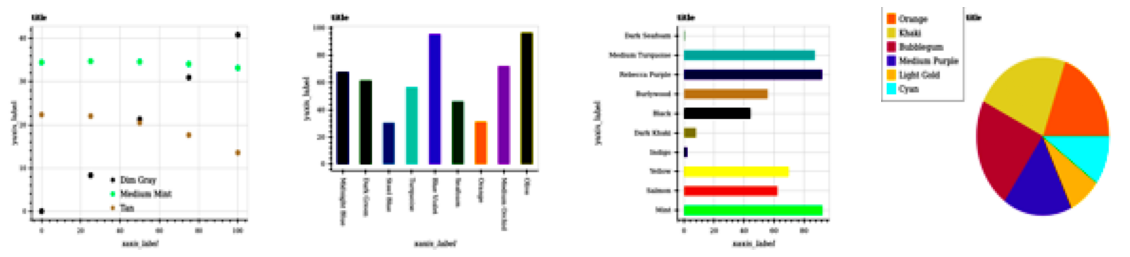

In [81]:
plt.figure()
f, ax = plt.subplots(1,4, figsize=(20,8)) 
img1 = train_features[0]
img2 = train_features[1]
img3 = train_features[2]
img4 = train_features[3]


ax[0].imshow(img1.permute(1,2,0), cmap='gray')
# ax[0]('off')
ax[1].imshow(img2.permute(1,2,0),cmap='gray')
ax[2].imshow(img3.permute(1,2,0),cmap='gray')
ax[3].imshow(img4.permute(1,2,0),cmap='gray')
[axi.set_axis_off() for axi in ax.ravel()]


In [5]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Dense Layer
        self.fc1 = nn.Linear(26912, 5) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        
        # Max pool 1
        out = self.maxpool1(out)
        
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
                
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = torch.flatten(out,1)
        # Dense Layer
        out = self.fc1(out)
        
        return out

batch_size = 16
num_epochs = 20
model = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [7]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [8]:
import tqdm
if torch.cuda.is_available():
    model.cuda()
for e in (range(1, num_epochs)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred.squeeze(), y_val_batch)
            val_acc = multi_acc(y_val_pred.squeeze(), y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Epoch 01: | Train Loss: 1.62043 | Val Loss: 1.14200 | Train Acc: 61.440| Val Acc: 69.000
Epoch 02: | Train Loss: 0.75437 | Val Loss: 0.51824 | Train Acc: 73.320| Val Acc: 88.000
Epoch 03: | Train Loss: 0.28646 | Val Loss: 0.13433 | Train Acc: 89.020| Val Acc: 94.000
Epoch 04: | Train Loss: 0.48147 | Val Loss: 0.61551 | Train Acc: 83.780| Val Acc: 62.000
Epoch 05: | Train Loss: 0.34631 | Val Loss: 0.25349 | Train Acc: 89.220| Val Acc: 88.000
Epoch 06: | Train Loss: 0.09243 | Val Loss: 0.03542 | Train Acc: 97.000| Val Acc: 100.000
Epoch 07: | Train Loss: 0.03551 | Val Loss: 0.07616 | Train Acc: 99.160| Val Acc: 100.000
Epoch 08: | Train Loss: 0.02062 | Val Loss: 0.00010 | Train Acc: 99.280| Val Acc: 100.000
Epoch 09: | Train Loss: 0.00891 | Val Loss: 0.00054 | Train Acc: 99.760| Val Acc: 100.000
Epoch 10: | Train Loss: 0.00625 | Val Loss: 0.00000 | Train Acc: 99.880| Val Acc: 100.000
Epoch 11: | Train Loss: 0.00143 | Val Loss: 0.00845 | Train Acc: 100.000| Val Acc: 100.000
Epoch 12: | Tr

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

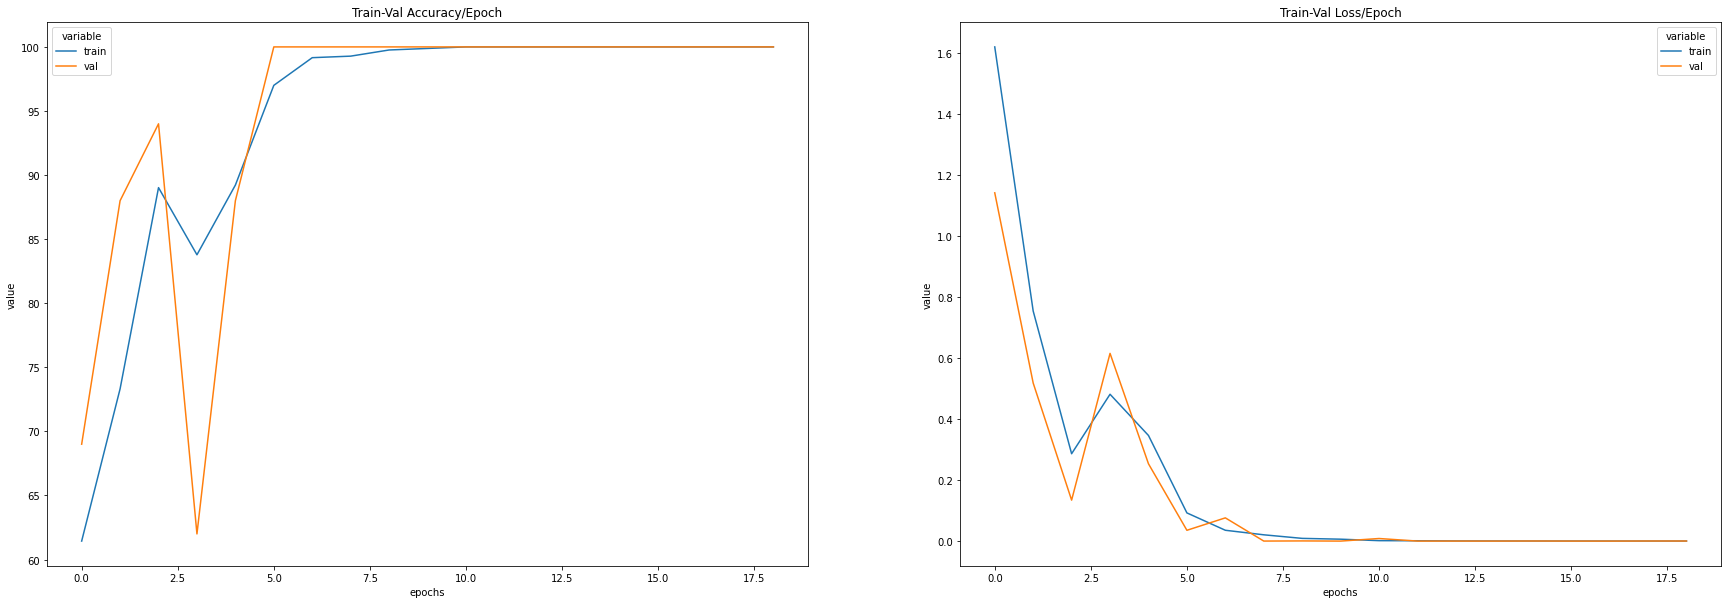

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


### For making predictions on test set. 

In [ ]:
## Test data must be loaded into Pytorch Dataloader
import glob 
from PIL import Image
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.png')
        self.transform = transform

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.image_paths)
dataset_test = TestDataset("test/", transform= image_transforms["test"])
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=16)


In [ ]:
## Making Predictions
y_pred_list = []
with torch.no_grad():
    for x_batch in (test_loader):
        x_batch = x_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        # y_true_list.append(y_batch.cpu().numpy())

## Unflatten the prediction list        
import itertools
final_preds = list(itertools.chain(*y_pred_list))


## Task 3 - Pretraining Resnet 50

In [9]:
import torchvision
model = torchvision.models.wide_resnet50_2(pretrained=True)

for param in model.parameters():
    param.required_grad = False


num_ftrt = model.fc.in_features

model.fc = nn.Linear(num_ftrt,5)
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)


In [11]:
epochs = 10

# track change in validation loss
valid_loss_min = np.Inf
val_loss = []
tn_loss = []
for epoch in range(1,epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):       
        if True:
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)


    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        if True:
            data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    scheduler.step()
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 1 	 Training Loss: 0.472 	 Validation Loss: 0.033
Validation loss decreased inf--->0.0325  Saving model...
Learning Rate ------------->0.0100
Epoch: 2 	 Training Loss: 0.088 	 Validation Loss: 0.009
Validation loss decreased 0.0325--->0.0095  Saving model...
Learning Rate ------------->0.0100
Epoch: 3 	 Training Loss: 0.029 	 Validation Loss: 0.003
Validation loss decreased 0.0095--->0.0033  Saving model...
Learning Rate ------------->0.0100
Epoch: 4 	 Training Loss: 0.031 	 Validation Loss: 0.003
Validation loss decreased 0.0033--->0.0030  Saving model...
Learning Rate ------------->0.0006
Epoch: 5 	 Training Loss: 0.015 	 Validation Loss: 0.003
Learning Rate ------------->0.0006
Epoch: 6 	 Training Loss: 0.018 	 Validation Loss: 0.003
Validation loss decreased 0.0030--->0.0025  Saving model...
Learning Rate ------------->0.0000
Epoch: 7 	 Training Loss: 0.017 	 Validation Loss: 0.003
Learning Rate ------------->0.0000
Epoch: 8 	 Training Loss: 0.028 	 Validation Loss: 0.002
Va

In [ ]:
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/new")
summary(model.cuda(), (3,128,128))

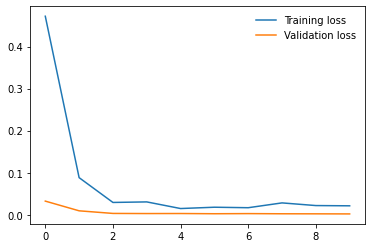

In [12]:
import matplotlib.pyplot as plt
plt.plot(tn_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=False)


plt.show()

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch in (test_loader):
        x_batch = x_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        # y_true_list.append(y_batch.cpu().numpy())
